# 朴素贝叶斯文本分类器
https://github.com/lining0806/Naive-Bayes-Classifier

**数据：**搜狗文本分类语料库

**分类器：**朴素贝叶斯分类器 NBC(Naive Bayesian Classifier)

**编程语言：**Python+jieba分词库+nltk+sklearn

升级到 Python 3.7 by David 2020.8.24

In [23]:
import os
import time
import random
import jieba
import nltk
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [86]:
def MakeWordsSet(words_file):
    words_set = set()
    with open(words_file, 'rb') as fp:
        for line in fp.readlines():
            word = line.strip().decode("utf-8")
            if len(word)>0 and word not in words_set: # 去重
                words_set.add(word)
    return words_set

In [87]:
def TextProcessing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []

    # 类间循环
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)
        files = os.listdir(new_folder_path)
        # 类内循环
        j = 1
        for file in files:
            if j > 100: # 每类text样本数最多100
                break
            with open(os.path.join(new_folder_path, file), 'rb') as fp:
                raw = fp.read()
            # print raw
            ## --------------------------------------------------------------------------------
            ## jieba分词
            # jieba.enable_parallel(4) # 开启并行分词模式，参数为并行进程数，不支持windows
            word_cut = jieba.cut(raw, cut_all=False) # 精确模式，返回的结构是一个可迭代的genertor
            word_list = list(word_cut) # genertor转化为list，每个词unicode格式
            # jieba.disable_parallel() # 关闭并行分词模式
            # print word_list
            ## --------------------------------------------------------------------------------
            data_list.append(word_list)
            class_list.append(folder.encode('utf-8').decode('utf-8'))
            j += 1

    ## 划分训练集和测试集
    # train_data_list, test_data_list, train_class_list, test_class_list = sklearn.cross_validation.train_test_split(data_list, class_list, test_size=test_size)
    data_class_list = list(zip(data_list, class_list))
    random.shuffle(data_class_list)
    index = int(len(data_class_list)*test_size)+1
    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list, train_class_list = zip(*train_list)
    test_data_list, test_class_list = zip(*test_list)

    # 统计词频放入all_words_dict
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict:
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1
    # key函数利用词频进行降序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) # 内建函数sorted参数需为list
    all_words_list = list(list(zip(*all_words_tuple_list))[0])

    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

In [94]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    # 选取特征词
    feature_words = []
    n = 1
    for t in range(deleteN, len(list(all_words_list)), 1):
        if n > 1000: # feature_words的维度1000
            break
        # print all_words_list[t]
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1<len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words

In [95]:
def TextFeatures(train_data_list, test_data_list, feature_words, flag='nltk'):
    def text_features(text, feature_words):
        text_words = set(text)
        ## -----------------------------------------------------------------------------------
        if flag == 'nltk':
            ## nltk特征 dict
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == 'sklearn':
            ## sklearn特征 list
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []
        ## -----------------------------------------------------------------------------------
        return features
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list

In [96]:
def TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='nltk'):
    ## -----------------------------------------------------------------------------------
    if flag == 'nltk':
        ## nltk分类器
        train_flist = zip(train_feature_list, train_class_list)
        test_flist = zip(test_feature_list, test_class_list)
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        # print classifier.classify_many(test_feature_list)
        # for test_feature in test_feature_list:
        #     print classifier.classify(test_feature),
        # print ''
        test_accuracy = nltk.classify.accuracy(classifier, test_flist)
    elif flag == 'sklearn':
        ## sklearn分类器
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
        # print classifier.predict(test_feature_list)
        # for test_feature in test_feature_list:
        #     print classifier.predict(test_feature)[0],
        # print ''
        test_accuracy = classifier.score(test_feature_list, test_class_list)
    else:
        test_accuracy = []
    return test_accuracy

In [102]:
## 文本预处理
folder_path = 'Database/SogouC/Sample'
all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path, test_size=0.2)

In [103]:
# 生成stopwords_set
stopwords_file = 'stopwords_cn.txt'
stopwords_set = MakeWordsSet(stopwords_file)

In [104]:
## 文本特征提取和分类     
# flag = 'nltk'
flag = 'sklearn'
deleteNs = range(0, 1000, 20)
test_accuracy_list = []
for deleteN in deleteNs:
        # feature_words = words_dict(all_words_list, deleteN)
        feature_words = words_dict(all_words_list, deleteN, stopwords_set)
        train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words, flag)
        test_accuracy = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag)
        test_accuracy_list.append(test_accuracy)
print(test_accuracy_list)

[0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.6842105263157895, 0.631578947368421, 0.6842105263157895, 0.7368421052631579, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.7368421052631579, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.631578947368421, 0.5789473684210527, 0.631578947368421, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.631578947368421, 0.631578947368421, 0.5789473684210527, 0.5263157894736842, 0.5263157894736842, 0.5263157894736842, 0.5263157894736842, 0.5263157894736842, 0.5263157894736842, 0.5263157894736842, 0.5263157894736842, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527]


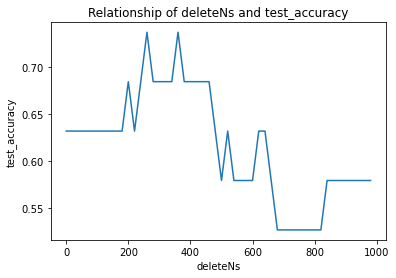

In [105]:
# 结果评价
plt.figure()
plt.plot(deleteNs, test_accuracy_list)
plt.title('Relationship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')
plt.savefig('result.png')